<ipython-input-2-3828100308>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['BMI'] = (df_clean['Weight'] * 703) / (df_clean['Height'] ** 2)
<ipython-input-2-3828100308>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(['Weight', 'Height'], axis=1, inplace=True)


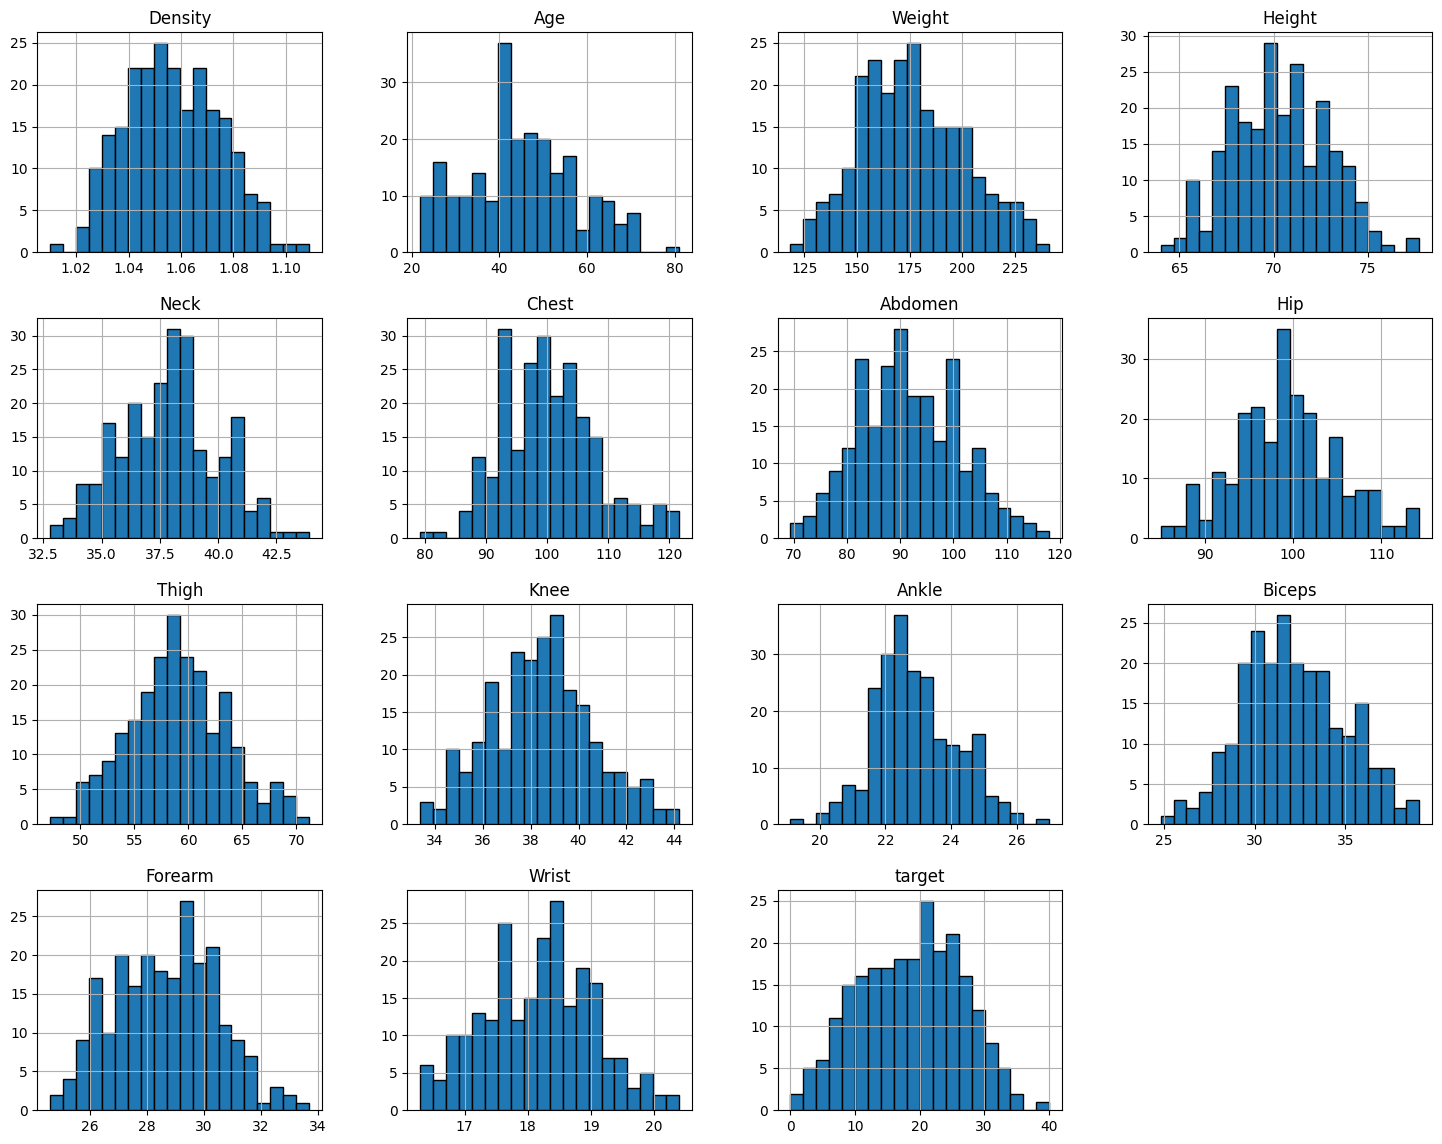

In [2]:
# بارگزای دیتا و پری پروسینگ
from sklearn.datasets import fetch_openml
import pandas as pd
dataset = fetch_openml(data_id = 560 , as_frame =True)
df = dataset.frame

df = df.rename(columns={'class':'target'})


Q1 = df.quantile(0.25)       # حذف داده های پرت
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df_clean = df[~outliers.any(axis=1)]
df_clean.hist(bins=20, figsize=(18, 14), edgecolor='black')

# ساخت ویژگی جدید و ترکیب ستون قد و وزن
df_clean['BMI'] = (df_clean['Weight'] * 703) / (df_clean['Height'] ** 2)
df_clean.drop(['Weight', 'Height'], axis=1, inplace=True)

In [3]:
# تقسیم داده ها به تست و ترین

from sklearn.model_selection import train_test_split

x = df_clean.drop(columns='target')     # ویژگی‌ها (DataFrame)
y = df_clean['target']                  # متغیر هدف (Series)

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.2 , random_state=42)

In [34]:
# َساخت پایپ لاین
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('model',GradientBoostingRegressor(
        n_estimators=100,
        learning_rate= 0.1,
        max_depth=3,
        random_state = 42
    ))
])

In [35]:
# فیت کردن مدل
gbr_pipeline.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=42))])

In [36]:
# پیش بینی مدل
y_pred = gbr_pipeline.predict(x_test)

In [37]:
# ارزیابی عملکرد مدل
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)
MAE ,MSE , R2

(0.43787975826826886, 1.471025902817654, 0.9757087512188682)

In [40]:
# هایپر پارامتر ها و تنظیم
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators':[50,100,150],
    'model__learning_rate':[1.0,0.5,0.1,0.01],
    'model__max_depth':[3,4,5]
}

grid_search = GridSearchCV(
    estimator = gbr_pipeline,
    param_grid=param_grid,
    cv = 5,
    scoring = 'r2',
    n_jobs = -1
)


In [41]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [1.0, 0.5, 0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150]},
             scoring='r2')

In [47]:
# پیش بینی با بهترین مدل
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

# ارزیابی عملکرد مدل
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
MAE = mean_absolute_error(y_test,y_pred_best)
MSE = mean_squared_error(y_test,y_pred_best)
R2 = r2_score(y_test,y_pred_best)
MAE ,MSE , R2

(0.4220191856132438, 1.7730664451720846, 0.9707211150784943)

In [48]:
# مشخص کردن اهمیت فیچر ها
feature_importances = best_model.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,Density,0.979553
1,Chest,0.004391
2,Knee,0.003105
3,Neck,0.002999
4,Abdomen,0.002937
5,Wrist,0.002730
6,BMI,0.001862
7,Age,0.001118
8,Thigh,0.000656
9,Biceps,0.000243


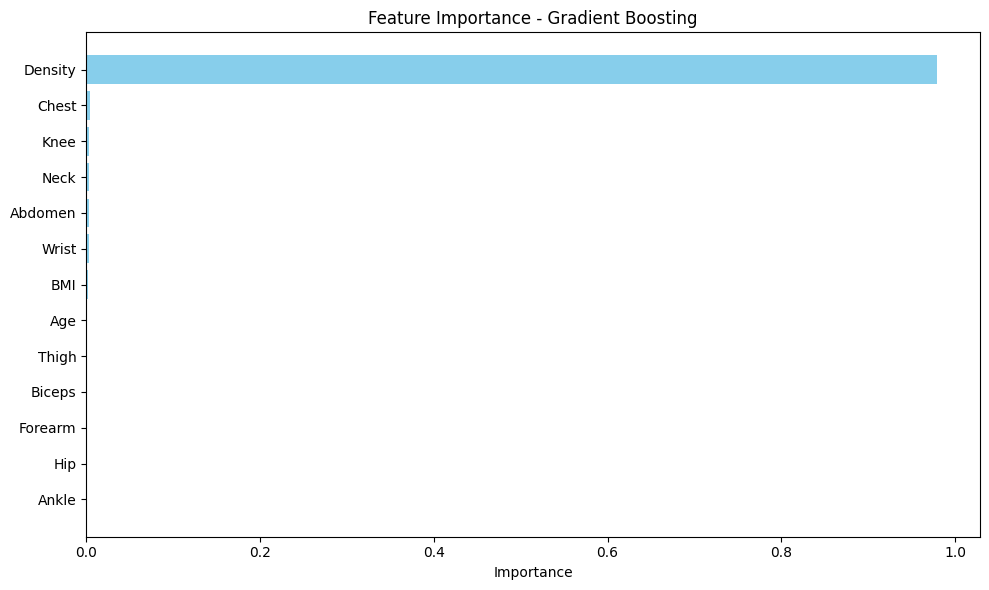

In [49]:
# نمایش دادن بهترین فیچر ها
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()

In [46]:
import joblib
joblib.dump(best_model, 'gradient_boosting_model.pkl')